# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

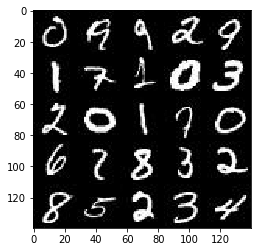

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

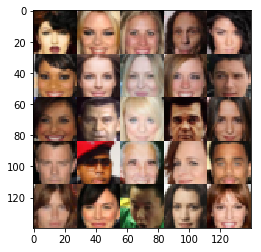

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input ==> 28x28x1 or 28x28x3
        layer_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer_1 = tf.maximum(layer_1*alpha, layer_1)
        
        # Input ==> 14x14x64
        layer_2 = tf.layers.conv2d(layer_1, 128, 5, strides=2, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(layer_2*alpha, layer_2)
        
        # Input ==> 7x7x128
        layer_3 = tf.layers.conv2d(layer_2, 256, 5, strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(layer_3*alpha, layer_3)
        
        # Output ==> 4x4x256
        # Flatten
        flat = tf.reshape(layer_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully Connected
        layer_1 = tf.layers.dense(z, 7*7*512, activation=None)
        
        # Reshape for Convolutional Stack
        layer_1 = tf.reshape(layer_1, (-1, 7, 7, 512))
        
        # Normalize
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        
        # Input ==> 7x7x512
        layer_2 = tf.layers.conv2d_transpose(layer_1, 256, 5, strides=2, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
        
        # Input ==> 14x14x256
        layer_3 = tf.layers.conv2d_transpose(layer_2, 128, 5, strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        
        # Input ==> 28x28x128
        logits = tf.layers.conv2d_transpose(layer_3, out_channel_dim, 5, strides=1, padding='same')
        
        # Input ==> 28x28xout_channel_dim
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Generator Model
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator (Model, Logits)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Losses
    g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the Weights and Bias to Update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Build the GAN
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    show_every = 100
    print_every = 10
    n_images = 16
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Rescale images to be between -1 & 1.  Coming in between -0.5 & 0.5
                batch_images = batch_images * 2
                # Sample random noise for the Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run the Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    # End of Epoch, get losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save the losses.  Might want to view later after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
                    
                    
        saver.save(sess, './checkpoints/generator.ckpt')
                    
        return losses         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0485... Generator Loss: 4.3078
Epoch 1/2... Discriminator Loss: 0.0441... Generator Loss: 5.3986
Epoch 1/2... Discriminator Loss: 0.5048... Generator Loss: 1.4783
Epoch 1/2... Discriminator Loss: 1.8540... Generator Loss: 5.2481
Epoch 1/2... Discriminator Loss: 0.3582... Generator Loss: 2.3552
Epoch 1/2... Discriminator Loss: 0.7193... Generator Loss: 1.6049
Epoch 1/2... Discriminator Loss: 0.8036... Generator Loss: 1.4032
Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 1.1848
Epoch 1/2... Discriminator Loss: 1.1483... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 2.1953


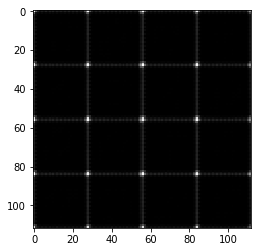

Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 1.2865
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 0.9171
Epoch 1/2... Discriminator Loss: 1.0318... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 0.8442
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 0.5963
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 0.8590
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 1.2227
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 0.5731


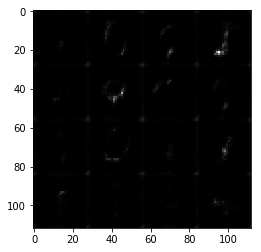

Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.4569
Epoch 1/2... Discriminator Loss: 0.9614... Generator Loss: 1.5350
Epoch 1/2... Discriminator Loss: 0.9682... Generator Loss: 0.9480
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 0.5731
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 0.7349
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 0.4327
Epoch 1/2... Discriminator Loss: 0.9682... Generator Loss: 1.3150
Epoch 1/2... Discriminator Loss: 1.0278... Generator Loss: 0.7354


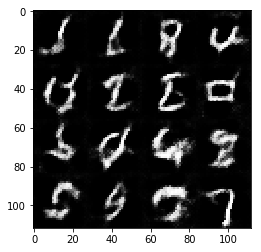

Epoch 1/2... Discriminator Loss: 0.9049... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 0.9008... Generator Loss: 1.1471
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 0.7368
Epoch 1/2... Discriminator Loss: 1.0160... Generator Loss: 1.4807
Epoch 1/2... Discriminator Loss: 1.0206... Generator Loss: 0.8904
Epoch 1/2... Discriminator Loss: 0.9630... Generator Loss: 0.8553
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 1.6364
Epoch 1/2... Discriminator Loss: 1.0277... Generator Loss: 0.9875
Epoch 1/2... Discriminator Loss: 1.0080... Generator Loss: 0.7663


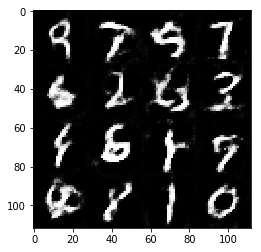

Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 1.9426
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.1015
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 2.1409
Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 0.6362
Epoch 1/2... Discriminator Loss: 1.0415... Generator Loss: 1.2525
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 0.8168
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.8616
Epoch 2/2... Discriminator Loss: 1.1549... Generator Loss: 1.8625
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.0748


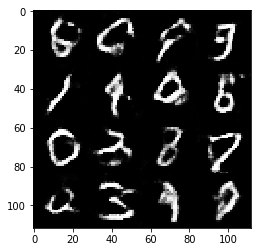

Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 0.5571
Epoch 2/2... Discriminator Loss: 0.9863... Generator Loss: 1.1297
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 1.0257
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 1.5136
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 1.2352
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 0.7144


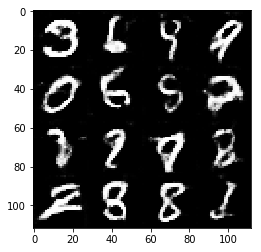

Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 1.1290
Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 0.7230
Epoch 2/2... Discriminator Loss: 0.8979... Generator Loss: 0.9339
Epoch 2/2... Discriminator Loss: 0.9779... Generator Loss: 0.7849
Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 0.4969
Epoch 2/2... Discriminator Loss: 1.6757... Generator Loss: 0.2829
Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 0.9606... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 0.8986... Generator Loss: 0.9063
Epoch 2/2... Discriminator Loss: 0.8785... Generator Loss: 1.3825


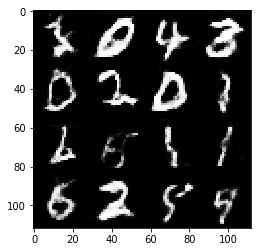

Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 1.5436
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 0.7961
Epoch 2/2... Discriminator Loss: 1.0886... Generator Loss: 2.2711
Epoch 2/2... Discriminator Loss: 0.9669... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 0.8670
Epoch 2/2... Discriminator Loss: 1.0111... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.5430... Generator Loss: 0.3060
Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 2.1327


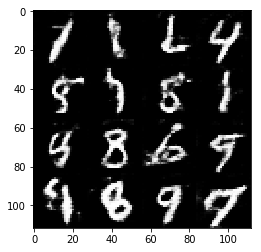

Epoch 2/2... Discriminator Loss: 1.1480... Generator Loss: 0.6087
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.8512
Epoch 2/2... Discriminator Loss: 0.8787... Generator Loss: 1.2022
Epoch 2/2... Discriminator Loss: 0.9800... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 1.2080
Epoch 2/2... Discriminator Loss: 0.9786... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.4617
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.5137
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.3798
Epoch 2/2... Discriminator Loss: 0.8759... Generator Loss: 0.9731


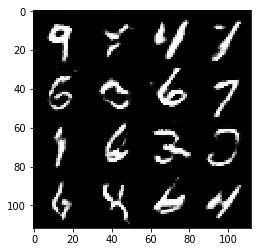

Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.5149
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 1.4208


In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
# tf.reset_default_graph()
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1540... Generator Loss: 2.4875
Epoch 1/1... Discriminator Loss: 0.0769... Generator Loss: 3.3195
Epoch 1/1... Discriminator Loss: 0.0460... Generator Loss: 4.2439
Epoch 1/1... Discriminator Loss: 0.0553... Generator Loss: 3.4845
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 11.8635
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.8127
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 4.5978
Epoch 1/1... Discriminator Loss: 0.3256... Generator Loss: 3.3453
Epoch 1/1... Discriminator Loss: 1.6747... Generator Loss: 5.7089


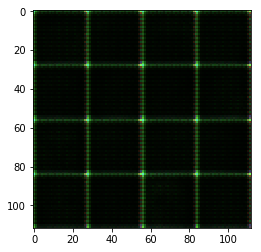

Epoch 1/1... Discriminator Loss: 0.5209... Generator Loss: 4.8485
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 2.3358
Epoch 1/1... Discriminator Loss: 0.2976... Generator Loss: 1.8422
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 0.1018... Generator Loss: 3.6194
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 5.1811
Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 2.2923
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 2.1732


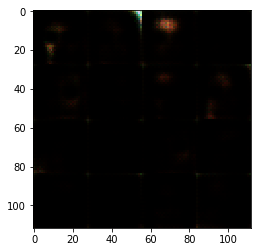

Epoch 1/1... Discriminator Loss: 0.2642... Generator Loss: 2.0900
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 3.8676
Epoch 1/1... Discriminator Loss: 0.1599... Generator Loss: 5.9852
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 0.2223... Generator Loss: 2.6473
Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 1.7384
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 0.3192... Generator Loss: 2.0801


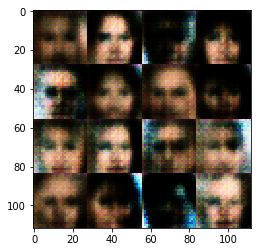

Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 1.8682
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 2.4842
Epoch 1/1... Discriminator Loss: 0.3787... Generator Loss: 2.6717
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 3.1483


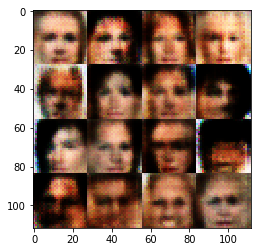

Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 3.1095
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.3351
Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 2.1067
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 2.4777
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.4015
Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 1.6495


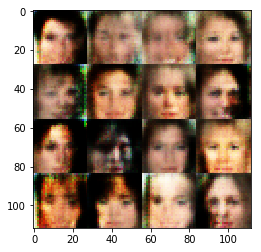

Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 4.8777
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 0.5259... Generator Loss: 1.9002
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.4238
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 3.9776
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 1.9857
Epoch 1/1... Discriminator Loss: 0.3255... Generator Loss: 2.3019


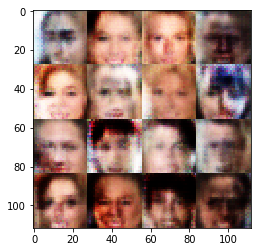

Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 2.2036
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 1.6917
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.6512
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.6223
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 0.4501... Generator Loss: 1.5714
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 1.0629


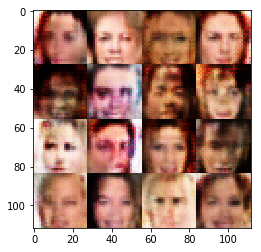

Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 2.9702
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 1.9977
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 1.8073
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 2.5931
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.5166


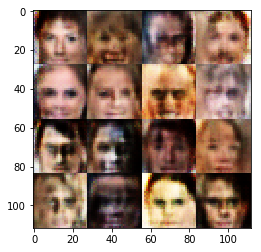

Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 2.4684
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 2.5418
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8448


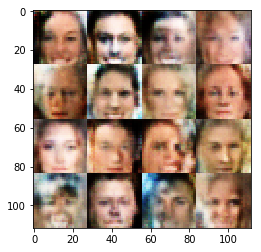

Epoch 1/1... Discriminator Loss: 1.6270... Generator Loss: 0.3294
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 2.5226
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 2.0030... Generator Loss: 0.1890
Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 2.8405


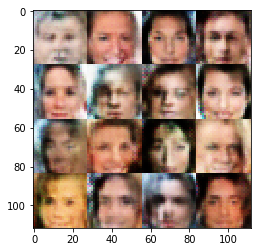

Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.9806
Epoch 1/1... Discriminator Loss: 0.6476... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 3.3584
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 1.2609
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.2948
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 1.2910


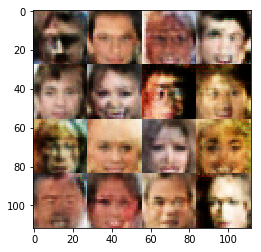

Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.3286
Epoch 1/1... Discriminator Loss: 2.1588... Generator Loss: 0.1625
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.8393
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 2.3746
Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 3.0851
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.4058


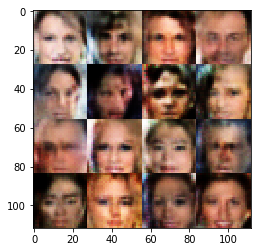

Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 2.9705
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.6984
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.4366
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 0.9058


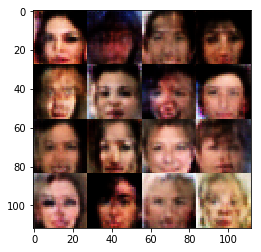

Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.2262
Epoch 1/1... Discriminator Loss: 0.3213... Generator Loss: 1.9871
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.3005
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 2.2697
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.5816


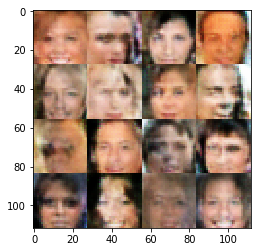

Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.3167
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 1.2628
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 2.2123
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.8011


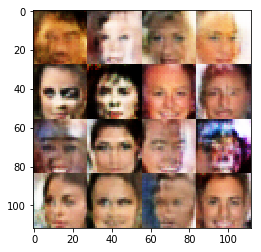

Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 0.7025... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 0.8559


In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.